In [14]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
import tensorflow as tf

In [15]:
# 输出当前使用的库版本
print("NumPy 版本:", np.__version__)
print("Pandas 版本:", pd.__version__)
# print("Matplotlib 版本:", plt.__version__)
print("Seaborn 版本:", sns.__version__)
print("Scikit-learn 版本:", sklearn.__version__)
print("TensorFlow 版本:", tf.__version__)
# print("Keras 版本:", keras.__version__)

NumPy 版本: 1.24.3
Pandas 版本: 2.0.3
Seaborn 版本: 0.12.2
Scikit-learn 版本: 1.3.0
TensorFlow 版本: 2.13.0


In [16]:
def del_no_pump_index(df):
    """
    Deletes the rows where the pump is not running
    """
    # df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    # 将第一个列设为索引
    orginal = df.shape[0]

    # 找出没有被pump的pump_index
    pump_index = df['pump_index'].unique()
    nopump_index = []
    nopump_symbol = []
    for i in pump_index:
        df_pump = df[df['pump_index'] == i]
        # 如果df_pump的列gt不存在等于1, 打印i
        if 1 not in df_pump['gt'].values:
            nopump_symbol.append(df_pump['symbol'].unique().tolist()[0])
            nopump_index.append(i)
    print('nopump_index: ', nopump_index)
    print('nopump_symbol: ', nopump_symbol)

    print('df.shape: ', df.shape)
    print(df['pump_index'].unique().shape)

    # 删除pump_index的值等于48的行
    for i in nopump_index:
        df = df.drop(df[df['pump_index'] == i].index)

    print('df_cleaned.shape: ', df.shape)
    print(df['pump_index'].unique().shape)
    now = df.shape[0]
    print('deleted: ', orginal - now)
    return df

In [148]:
def split_dataset(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    df = del_no_pump_index(df)

    # set random seed
    np.random.seed(2023)

    # train_num为训练集的数量, test_num为测试集的数量
    train_num=np.round(317*0.8) # 254
    test_num=317-train_num      # 63

    # 查看pump_index的值
    index = df['pump_index'].unique()

    # 选取index中的train_num个数作为训练集
    train_index = np.random.choice(index, int(train_num), replace=False)
    # 选取剩下的作为测试集
    test_index = np.setdiff1d(index, train_index)

    # 选取训练集, 选取测试集
    train = df[df['pump_index'].isin(train_index)]
    test = df[df['pump_index'].isin(test_index)]
    print(train.shape, test.shape)

    # 选取训练集的特征
    X_train = train.drop(['gt'], axis=1)
    y_train = train['gt']
    X_test = test.drop(['gt'], axis=1)
    y_test = test['gt']
    return X_train, y_train, X_test, y_test

In [149]:
X_train, y_train, X_test, y_test = split_dataset('5S')

nopump_index:  [48, 149, 156, 180, 224, 264, 300, 327, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'RDN', 'GRS', 'RDN', 'WINGS']
df.shape:  (821307, 16)
(327,)
df_cleaned.shape:  (821275, 16)
(317,)
deleted:  32
(676036, 16) (145239, 16)


In [144]:
X_train.drop(['date','pump_index','symbol'], axis=1, inplace=True)
X_test.drop(['date','pump_index','symbol'], axis=1, inplace=True)

In [140]:
X_train.shape

(676036, 13)

In [138]:
X_train.columns

Index(['date', 'pump_index', 'std_rush_order', 'avg_rush_order', 'std_trades',
       'std_volume', 'avg_volume', 'std_price', 'avg_price', 'avg_price_max',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'symbol'],
      dtype='object')

In [167]:
X_train, y_train, X_test, y_test = split_dataset('5S')
X_train.drop(['date','pump_index','symbol'], axis=1, inplace=True)
X_test.drop(['date','pump_index','symbol'], axis=1, inplace=True)

# normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# train normal data
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]
X_train = X_train_normal
y_train = y_train_normal

nopump_index:  [48, 149, 156, 180, 224, 264, 300, 327, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'RDN', 'GRS', 'RDN', 'WINGS']
df.shape:  (821307, 16)
(327,)
df_cleaned.shape:  (821275, 16)
(317,)
deleted:  32
(676036, 16) (145239, 16)


In [168]:
# --------------------------------------------------------------------------------------------------
def lstm_autoencoder(time_freq, X_train, y_train, X_test, y_test):
    X_train.drop(['date','pump_index','symbol'], axis=1, inplace=True)
    X_test.drop(['date','pump_index','symbol'], axis=1, inplace=True)

    # normalize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # train normal data
    X_train_normal = X_train[y_train == 0]
    y_train_normal = y_train[y_train == 0]
    X_train = X_train_normal
    y_train = y_train_normal

    # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # 构建LSTM自编码器模型
    reg = 0.0001
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    encoded = LSTM(32, activation='relu', return_sequences=True
                    , kernel_regularizer=regularizers.l2(reg)
                    )(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(X_train.shape[1])(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True,)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(decoded)
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')
    # adam = optimizers.Adam(learning_rate=0.0001)
    # autoencoder.compile(optimizer=adam, loss='mae')
    # autoencoder.summary()
    
    # 使用训练数据训练LSTM自编码器模型
    early_stopping = EarlyStopping(monitor='val_loss'
                                # , min_delta=0.0001
                                , patience=12
                                , verbose=1
                                # , mode='min'
                                , restore_best_weights=True)
    history= autoencoder.fit(X_train, X_train
                            , epochs=150
                            , batch_size=32
                            , validation_split=0.1
                            , callbacks=[early_stopping]
                            )

    # plot loss curve
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('LSTM-AutoEncoder Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # 使用训练好的LSTM自编码器重构训练数据
    X_train_pred = autoencoder.predict(X_train)
    X_train_pred = X_train_pred.reshape(X_train_pred.shape[0], X_train_pred.shape[2])
    trainX = X_train.reshape(X_train.shape[0], X_train.shape[2])

    # 计算还原误差MAE
    train_mae = np.mean(np.abs(trainX - X_train_pred), axis=1)

    # 使用训练好的LSTM自编码器重构测试数据
    X_test_pred = autoencoder.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    testX = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # 计算还原误差MAE
    test_mae = np.mean(np.abs(testX - X_test_pred), axis=1)

    return autoencoder, train_mae, y_train, test_mae, y_test



# --------------------------------------------------------------------------------------------------
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 1, 1000)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold
# ------------------------------set threshold--------------------------------------------------------
def set_threshold(y_test, test_mae, threshold):
    # 设置阈值
    threshold = threshold
    print("Reconstruction error threshold: ", threshold)
    y_test_pred = np.where(test_mae >= threshold , 1, 0)

    # precision, recall, f1-score
    print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))
    print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
    

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# LSTM AutoEncoder

- 25S

In [169]:
X_train, y_train, X_test, y_test = split_dataset('25S')

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (482157, 16)
(327,)
df_cleaned.shape:  (482137, 16)
(317,)
deleted:  20
(392728, 16) (89409, 16)


Epoch 1/150
11039/11039 [==============================] - 27s 2ms/step - loss: 0.1081 - val_loss: 0.0618
Epoch 2/150
11039/11039 [==============================] - 23s 2ms/step - loss: 0.0507 - val_loss: 0.0421
Epoch 3/150
11039/11039 [==============================] - 23s 2ms/step - loss: 0.0282 - val_loss: 0.0200
Epoch 4/150
11039/11039 [==============================] - 24s 2ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 5/150
11039/11039 [==============================] - 24s 2ms/step - loss: 0.0193 - val_loss: 0.0186
Epoch 6/150
11039/11039 [==============================] - 24s 2ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 7/150
11039/11039 [==============================] - 23s 2ms/step - loss: 0.0187 - val_loss: 0.0196
Epoch 8/150
11039/11039 [==============================] - 23s 2ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 9/150
11039/11039 [==============================] - 23s 2ms/step - loss: 0.0182 - val_loss: 0.0182
Epoch 10/150
11039/11039 [====================

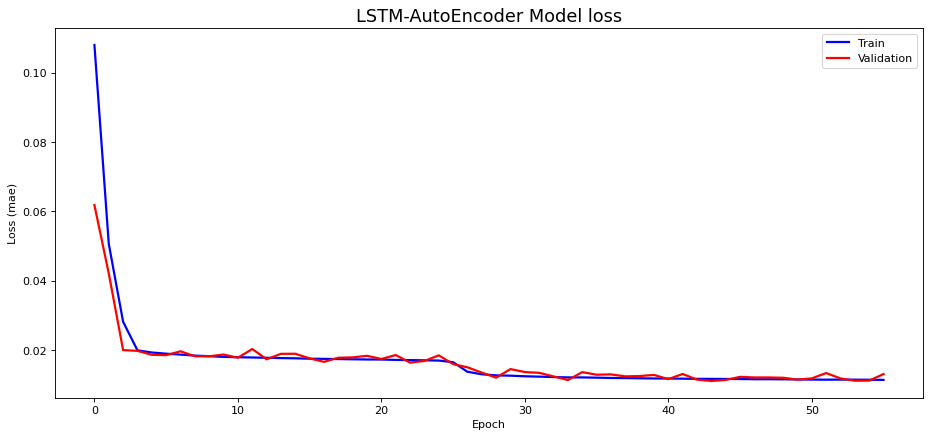

2795/2795 [==============================] - 3s 818us/step


In [170]:
autoencoder_25S, test_mae_25S, y_test_25S = lstm_autoencoder(time_freq='25S', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

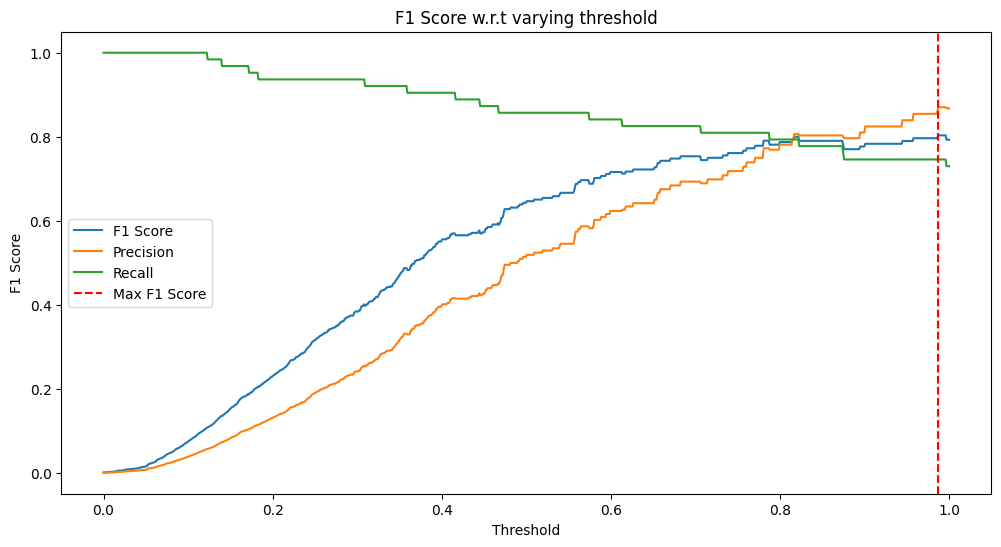

Best threshold:  0.986986986986987
Best F1 Score:  0.8034188034188035
Recall:  0.746031746031746
Precision:  0.8703703703703703


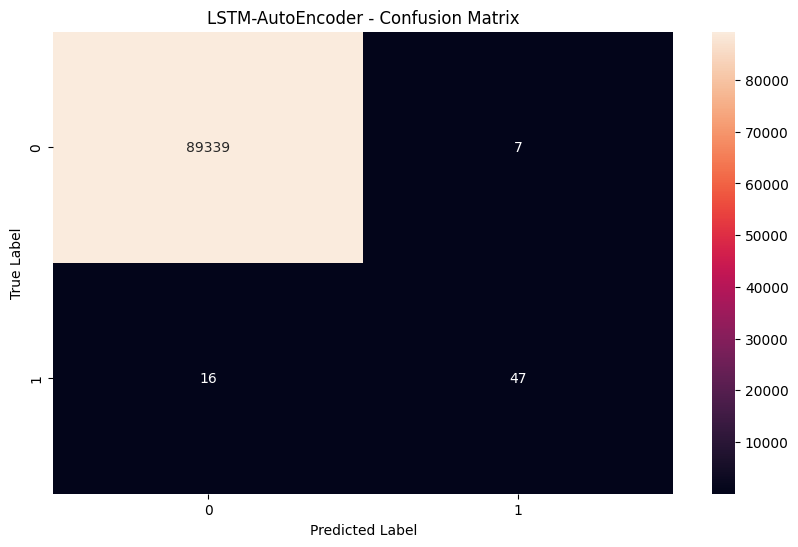

In [171]:
threshold_25S = pick_threshold(y_test_25S, test_mae_25S)

- 15S

nopump_index:  [48, 149, 156, 180, 224, 264, 299, 300, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'HC', 'RDN', 'RDN', 'WINGS']
df.shape:  (584104, 16)
(327,)
df_cleaned.shape:  (584081, 16)
(317,)
deleted:  23
Epoch 1/150
13135/13135 [==============================] - 33s 2ms/step - loss: 0.1270 - val_loss: 0.0834
Epoch 2/150
13135/13135 [==============================] - 26s 2ms/step - loss: 0.0636 - val_loss: 0.0566
Epoch 3/150
13135/13135 [==============================] - 25s 2ms/step - loss: 0.0571 - val_loss: 0.0581
Epoch 4/150
13135/13135 [==============================] - 25s 2ms/step - loss: 0.0563 - val_loss: 0.0559
Epoch 5/150
13135/13135 [==============================] - 25s 2ms/step - loss: 0.0404 - val_loss: 0.0273
Epoch 6/150
13135/13135 [==============================] - 25s 2ms/step - loss: 0.0252 - val_loss: 0.0241
Epoch 7/150
13135/13135 [==============================] - 25s 2ms/step - loss: 0.0234 - val_loss: 0.0213
Epoch 8/150
13135/1

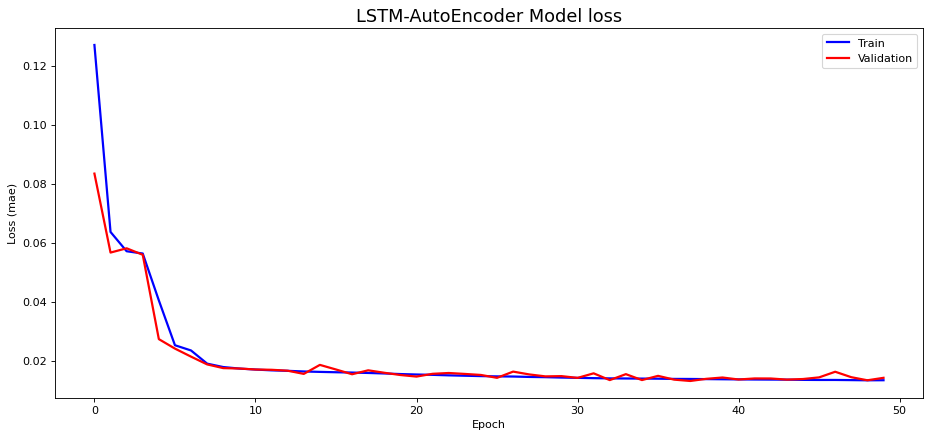

3659/3659 [==============================] - 3s 819us/step


In [40]:
autoencoder_15S, test_mae_15S, y_test_15S = lstm_autoencoder(time_freq='15S')

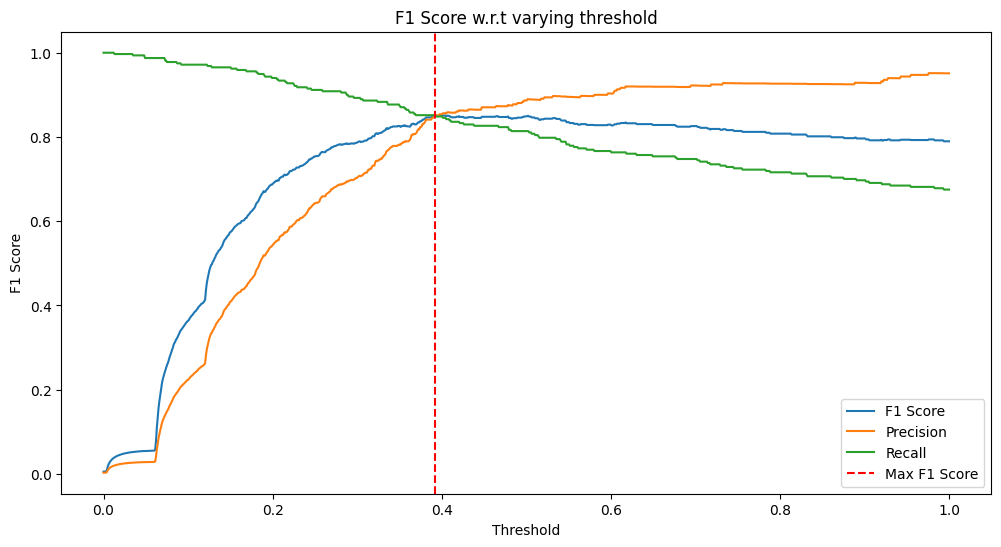

Best threshold:  0.3923923923923924
Best F1 Score:  0.8517350157728708
Recall:  0.8517350157728707
Precision:  0.8517350157728707


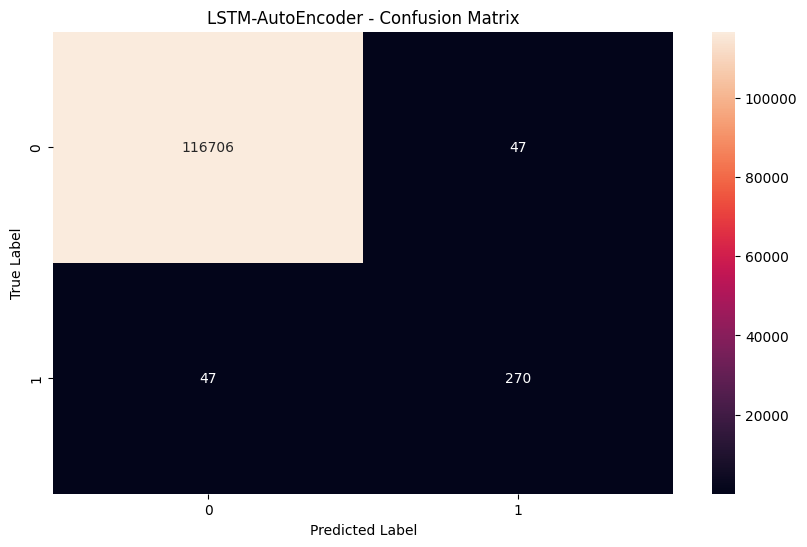

In [41]:
threshold_15S = pick_threshold(y_test_15S, test_mae_15S)

In [11]:
# threshold = threshold_15S
# set_threshold(y_test_15S, test_mae_15S, threshold)

- 5S

nopump_index:  [48, 149, 156, 180, 224, 264, 300, 327, 330, 331]
nopump_symbol:  ['YOYOW', 'DUSK', 'VIA', 'VIA', 'VIB', 'GXS', 'RDN', 'GRS', 'RDN', 'WINGS']
df.shape:  (821307, 16)
(327,)
df_cleaned.shape:  (821275, 16)
(317,)
deleted:  32
Epoch 1/150
18472/18472 [==============================] - 48s 2ms/step - loss: 0.1228 - val_loss: 0.0662
Epoch 2/150
18472/18472 [==============================] - 43s 2ms/step - loss: 0.0631 - val_loss: 0.0402
Epoch 3/150
18472/18472 [==============================] - 42s 2ms/step - loss: 0.0377 - val_loss: 0.0344
Epoch 4/150
18472/18472 [==============================] - 43s 2ms/step - loss: 0.0350 - val_loss: 0.0347
Epoch 5/150
18472/18472 [==============================] - 43s 2ms/step - loss: 0.0336 - val_loss: 0.0331
Epoch 6/150
18472/18472 [==============================] - 37s 2ms/step - loss: 0.0330 - val_loss: 0.0352
Epoch 7/150
18472/18472 [==============================] - 37s 2ms/step - loss: 0.0322 - val_loss: 0.0352
Epoch 8/150
18472/

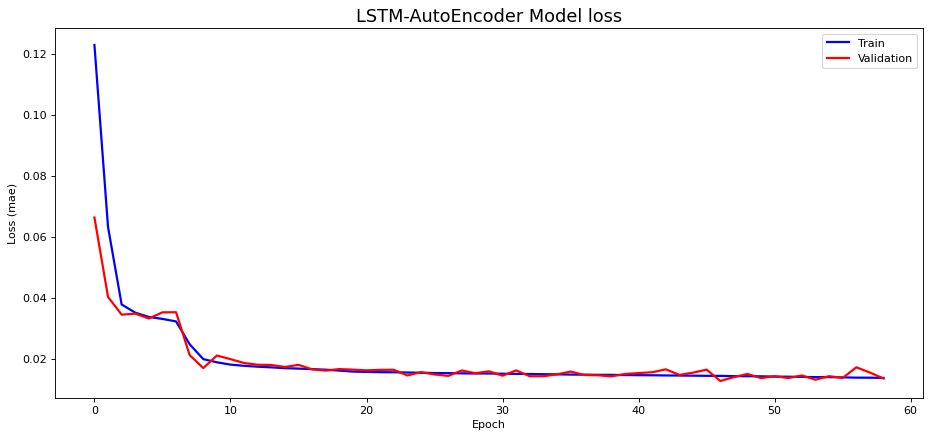

5141/5141 [==============================] - 4s 805us/step


In [42]:
autoencoder_5S, test_mae_5S, y_test_5S = lstm_autoencoder(time_freq='5S')

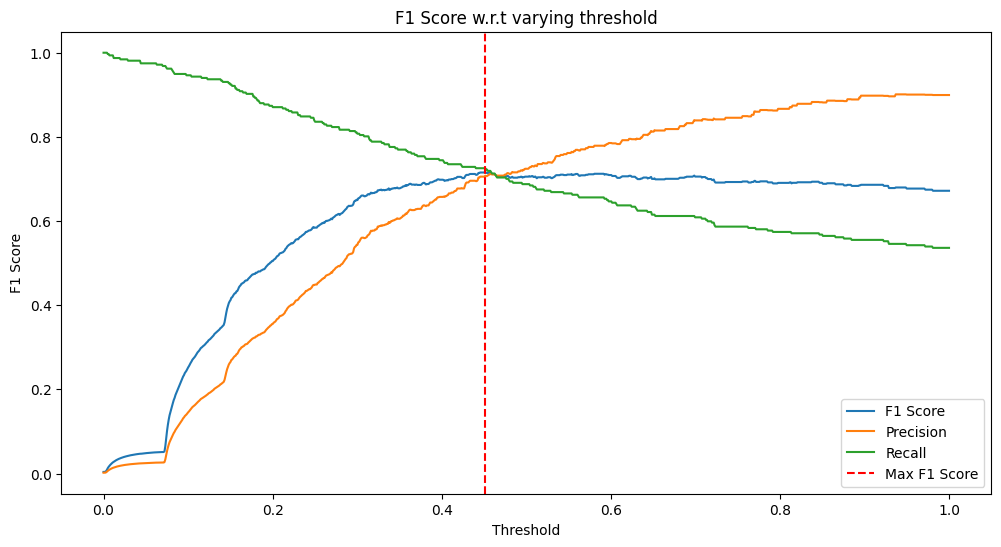

Best threshold:  0.45145145145145144
Best F1 Score:  0.7165109034267914
Recall:  0.7255520504731862
Precision:  0.7076923076923077


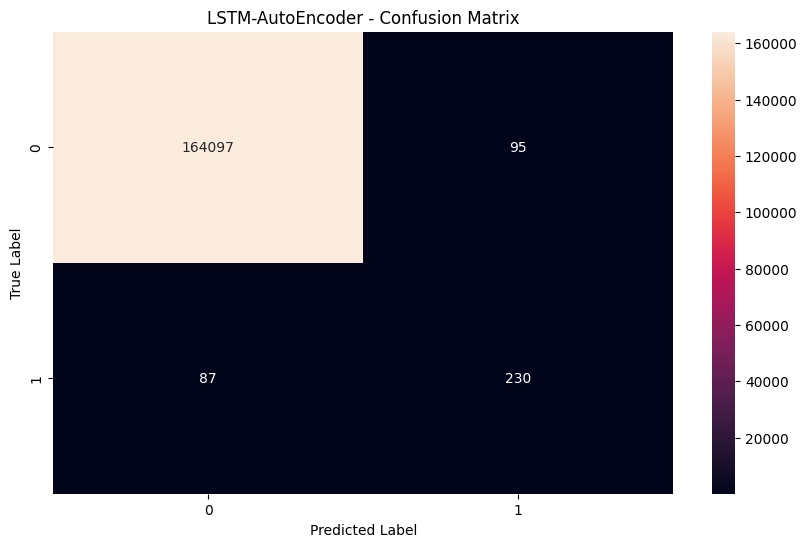

In [43]:
threshold_5S = pick_threshold(y_test_5S, test_mae_5S)

Best threshold:  0.32432432432432434
Best F1 Score:  0.7386172006745363
Recall:  0.6908517350157729
Precision:  0.7934782608695652

Reconstruction error threshold_5S:  0.45145145145145144
Reconstruction error threshold_15S:  0.3923923923923924
Reconstruction error threshold_25S:  0.3893893893893894
5S: F1 Score: 0.7165109034267914, Recall: 0.7255520504731862, Precision: 0.7076923076923077
15S: F1 Score: 0.8517350157728708, Recall: 0.8517350157728707, Precision: 0.8517350157728707
25S: F1 Score: 0.8881789137380192, Recall: 0.8769716088328076, Precision: 0.8996763754045307


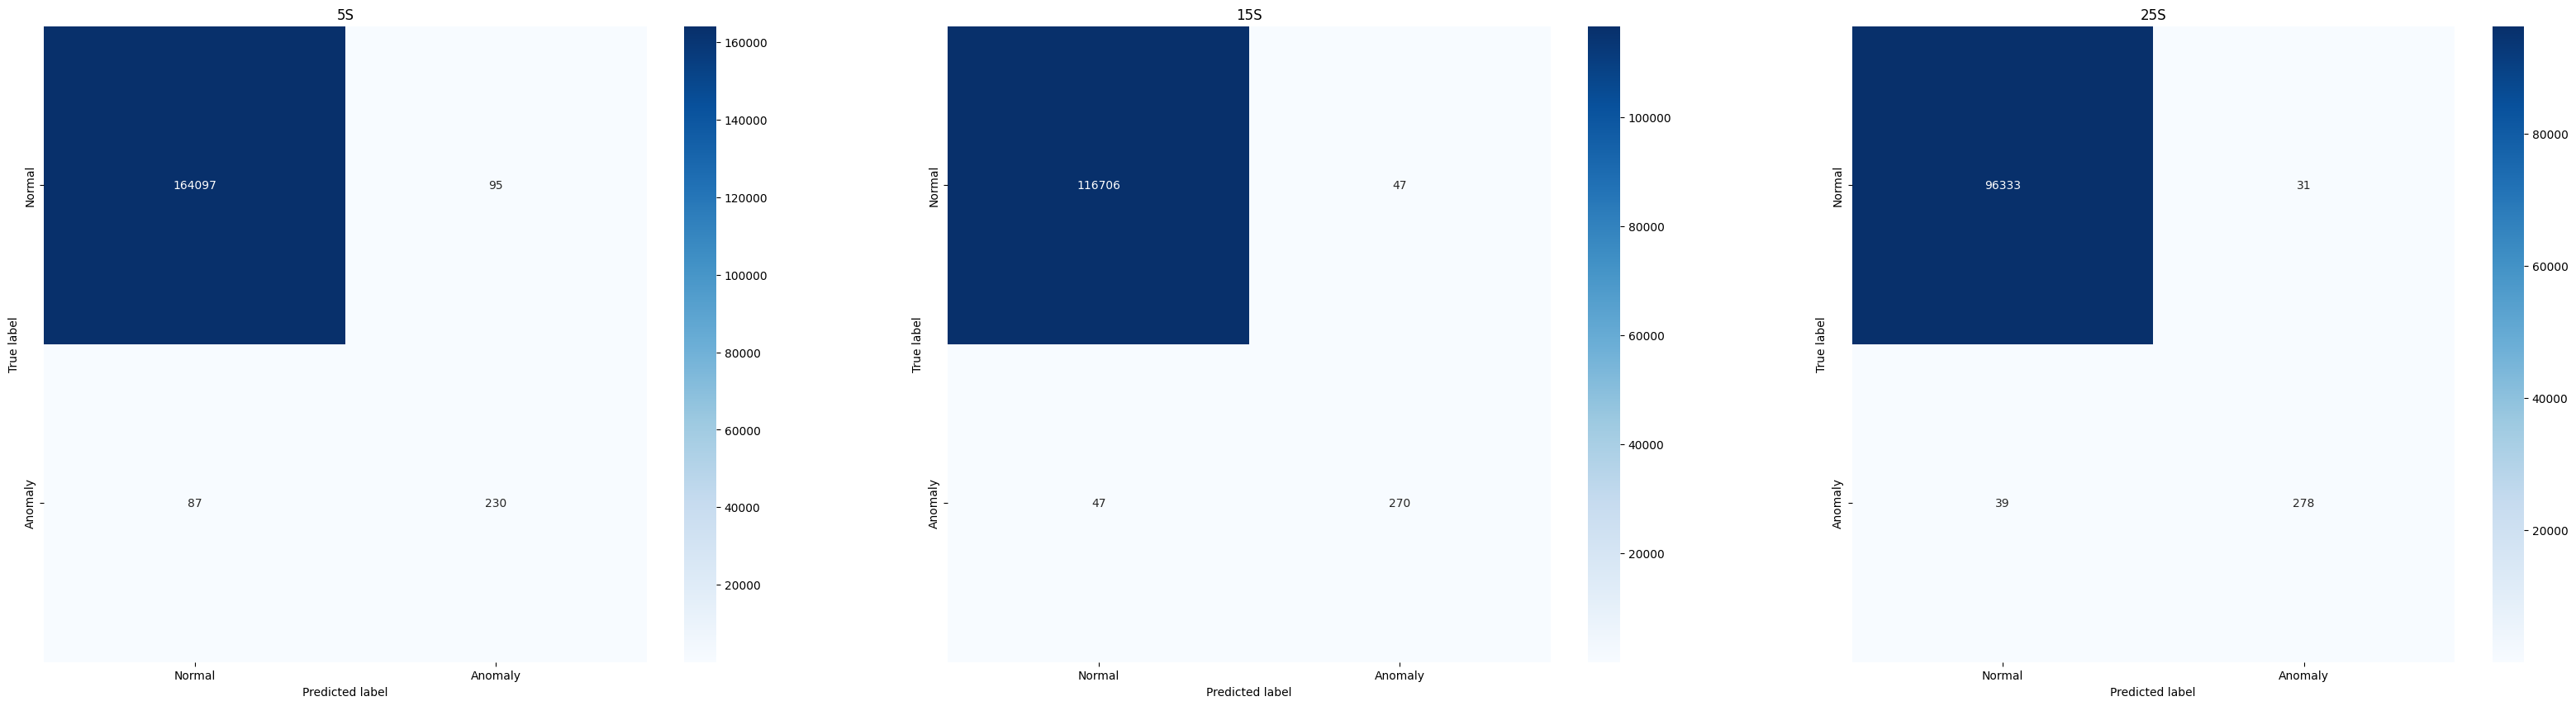

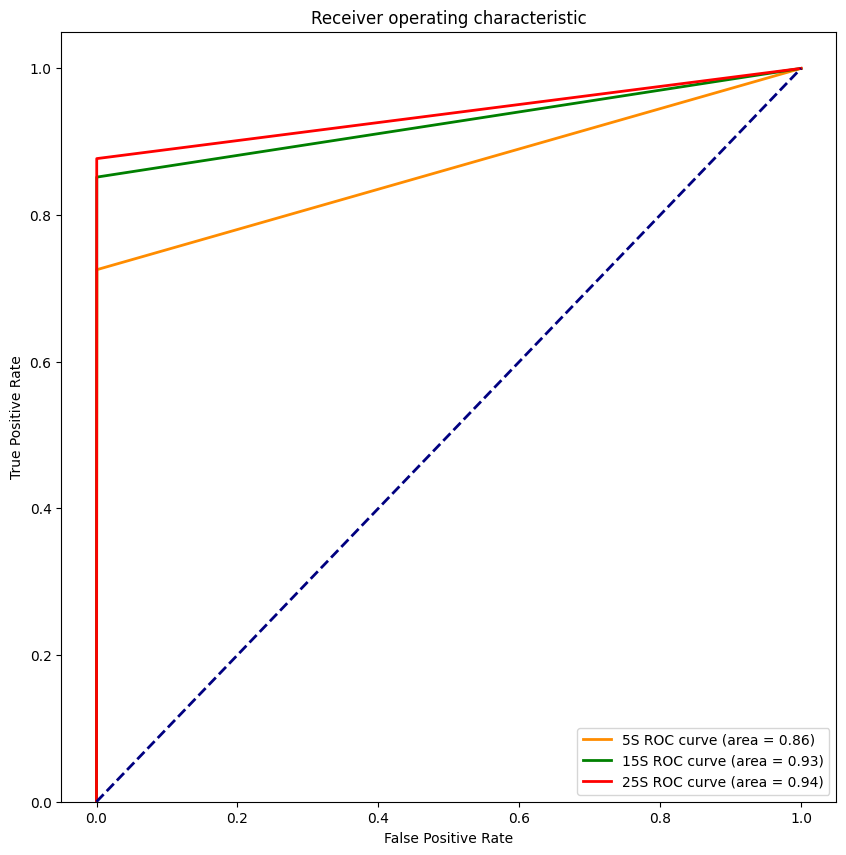

In [44]:
# 设置阈值
print("Reconstruction error threshold_5S: ", threshold_5S)
print("Reconstruction error threshold_15S: ", threshold_15S)
print("Reconstruction error threshold_25S: ", threshold_25S)

y_test_pred_5S = np.where(test_mae_5S >= threshold_5S , 1, 0)
y_test_pred_15S = np.where(test_mae_15S >= threshold_15S , 1, 0)
y_test_pred_25S = np.where(test_mae_25S >= threshold_25S , 1, 0)

# precision, recall, f1-score
from sklearn.metrics import f1_score, recall_score, precision_score
F1_score_5S = f1_score(y_test_5S, y_test_pred_5S)
Recall_5S = recall_score(y_test_5S, y_test_pred_5S)
Precision_5S = precision_score(y_test_5S, y_test_pred_5S)

F1_score_15S = f1_score(y_test_15S, y_test_pred_15S)
Recall_15S = recall_score(y_test_15S, y_test_pred_15S)
Precision_15S = precision_score(y_test_15S, y_test_pred_15S)

F1_score_25S = f1_score(y_test_25S, y_test_pred_25S)
Recall_25S = recall_score(y_test_25S, y_test_pred_25S)
Precision_25S = precision_score(y_test_25S, y_test_pred_25S)

print('5S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_5S, Recall_5S, Precision_5S))
print('15S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_15S, Recall_15S, Precision_15S))
print('25S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_25S, Recall_25S, Precision_25S))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_5S = confusion_matrix(y_test_5S, y_test_pred_5S)
confusion_matrix_15S = confusion_matrix(y_test_15S, y_test_pred_15S)
confusion_matrix_25S = confusion_matrix(y_test_25S, y_test_pred_25S)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


# plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_pred_5S)
roc_auc_5S = auc(fpr_5S, tpr_5S)

fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_pred_15S)
roc_auc_15S = auc(fpr_15S, tpr_15S)

fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_pred_25S)
roc_auc_25S = auc(fpr_25S, tpr_25S)

plt.figure(figsize=(10,10))
plt.plot(fpr_5S, tpr_5S, color='darkorange', lw=2, label='5S ROC curve (area = %0.2f)' % roc_auc_5S) # lw: line width
plt.plot(fpr_15S, tpr_15S, color='green', lw=2, label='15S ROC curve (area = %0.2f)' % roc_auc_15S) # lw: line width
plt.plot(fpr_25S, tpr_25S, color='red', lw=2, label='25S ROC curve (area = %0.2f)' % roc_auc_25S) # lw: line width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 画对角线
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('False Positive Rate') # x轴标签
plt.ylabel('True Positive Rate') # y轴标签
plt.title('Receiver operating characteristic') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()

In [ ]:
# threshold = threshold_5S
# set_threshold(y_test_5S, test_mae_5S, threshold_5S)

In [45]:
# # 设置阈值
# threshold_1 = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)
# threshold_2 = np.mean(test_mae_loss) - 3 * np.std(test_mae_loss)
# print("Reconstruction error threshold: ", threshold_1, threshold_2)
# y_test_pred = np.where((test_mae_loss >= threshold_1) | (test_mae_loss< threshold_2) , 1, 0)

# # precision, recall, f1-score
# print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))

# # plot confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('LSTM-AutoEncoder - Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()